!pip install pandas matplotlib

# LR transfer

In [21]:
import pandas as pd
from matplotlib import pyplot as plt

In [22]:
df = pd.read_csv('adam25.csv')
#df = pd.read_csv('sgd_mup.csv')
df = pd.read_csv('adam50.csv')
df = pd.read_csv('sgd25_old.csv')
df = pd.read_csv('sgd25.csv')

# remove rows with hidden_size in 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000
df = df[~df['hidden_size'].isin([500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])]

In [23]:
(df['lr'] == 10).sum()

np.int64(10)

In [24]:
def lr_curve(df, field, use_mup=None, minimize=True):
    # increase plot font size
    plt.rcParams.update({'font.size': 16})
    df2 = df.groupby(['hidden_size', 'use_mup'])
    for name, group in df2:
        if name[1]:
            if use_mup is not None and not use_mup:
                continue
            label = f'mup {name[0]}'
        else:
            if use_mup is not None and use_mup:
                continue
            label = f'std {name[0]}'
        group = group.sort_values('lr')
        if minimize:
            print(f"{name[0]}: {group['lr'].iloc[group[field].argmin().item()]}")
        else:
            print(f"{name[0]}: {group['lr'].iloc[group[field].argmax().item()]}")
        #print(group['lr'].iloc[-1])
        #print(group[field].iloc[-1])
        #print(len(group['lr']))
        #print(len(group[field]))
        plt.semilogx(group['lr'], group[field], label=label, marker='x', linestyle=':')
    plt.xlabel('lr')
    plt.ylabel(field)
    plt.legend()
    plt.show()

512: 1.0
1024: 1.0
2048: 1.0
4096: 1.0
9192: 1.0


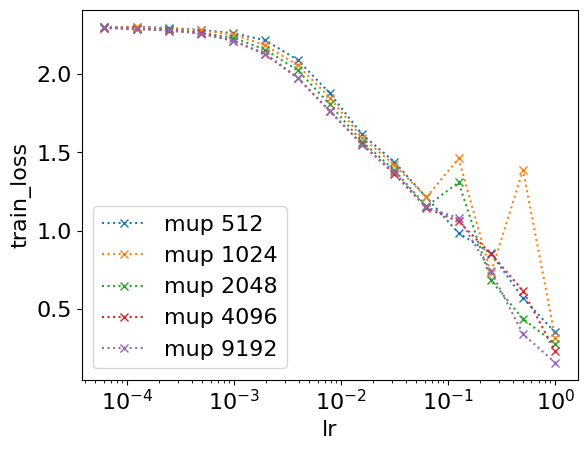

512: 0.125
1024: 0.5
2048: 0.125
4096: 0.125
9192: 0.125


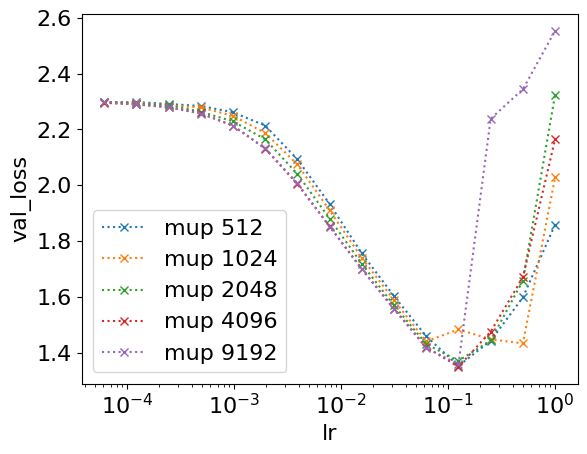

512: 0.125
1024: 0.25
2048: 0.5
4096: 0.5
9192: 0.125


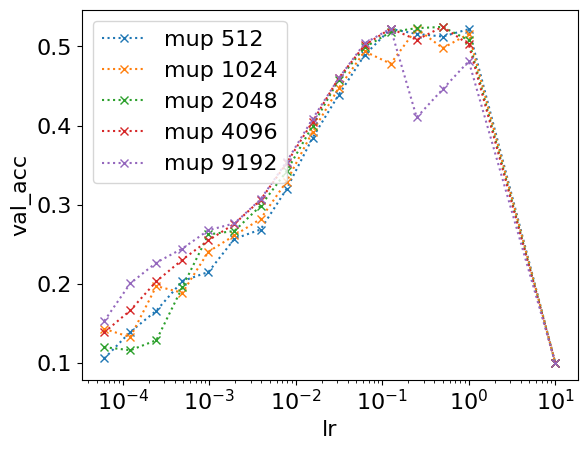

In [25]:
lr_curve(df, 'train_loss', use_mup=True)
lr_curve(df, 'val_loss', use_mup=True)
lr_curve(df, 'val_acc', use_mup=True, minimize=False)

512: 0.25
1024: 0.25
2048: 0.25
4096: 0.5
9192: 0.25


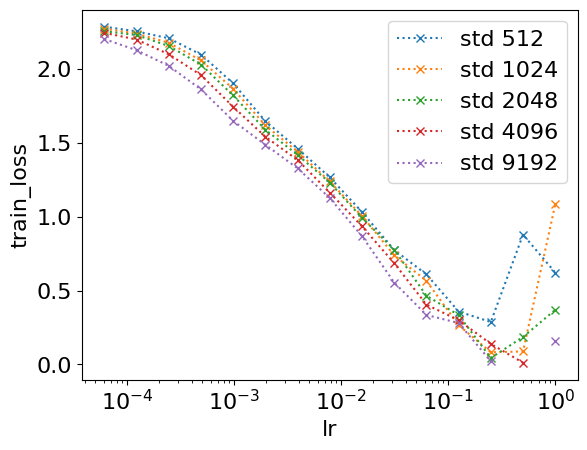

512: 0.01563
1024: 0.01563
2048: 0.01563
4096: 0.01563
9192: 0.01563


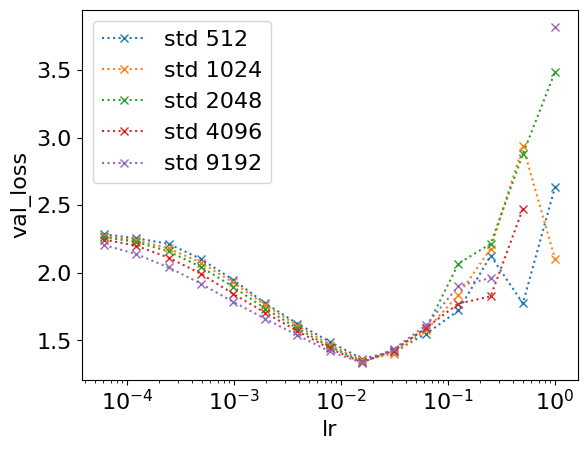

512: 0.125
1024: 0.25
2048: 0.25
4096: 0.5
9192: 0.25


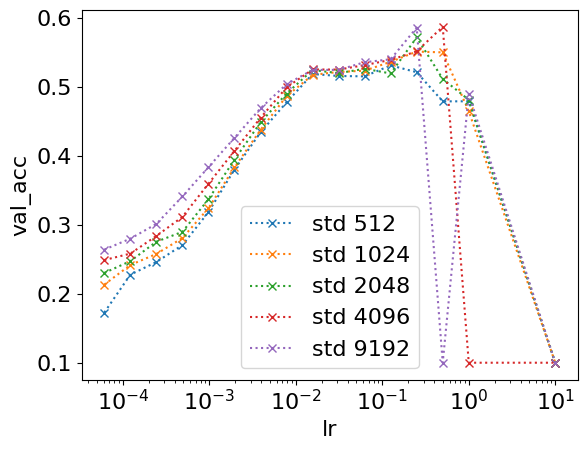

In [26]:
lr_curve(df, 'train_loss', use_mup=False)
lr_curve(df, 'val_loss', use_mup=False)
lr_curve(df, 'val_acc', use_mup=False, minimize=False)

# Coordinate check

!pip install wandb

!wandb login a3f45dd6719a8619b0c46df881e5470cacb08ba2

In [27]:
# let's fetch some data about the runs from wandb
import wandb
api = wandb.Api()
runs = api.runs("chrisxx/cifar10-sgd")
for run in runs:
    print(run.name, run.config['hidden_size'], run.config['use_mup'], run.config['lr'], run.summary['val_acc'])
    

std_sgd_w1024_lr0.001_e10_b128_2995 1024 False 0.001 0.2750999927520752
mup_sgd_w1024_lr0.001_e10_b128_3258 1024 True 0.001 0.1525000035762787
std_sgd_w2048_lr0.001_e10_b128_9493 2048 False 0.001 0.2872999906539917
mup_sgd_w2048_lr0.001_e10_b128_6012 2048 True 0.001 0.2079000025987625
std_sgd_w1024_lr0.001_e100_b128_1863 1024 False 0.001 0.4392000138759613
mup_sgd_w1024_lr0.001_e100_b128_2074 1024 True 0.001 0.28209999203681946
std_sgd_w2048_lr0.001_e100_b128_7245 2048 False 0.001 0.45010000467300415
mup_sgd_w2048_lr0.001_e100_b128_4640 2048 True 0.001 0.3000999987125397
std_sgd_w1024_lr6.103e-05_e25_b128_5098 1024 False 6.103e-05 0.2134000062942505
mup_sgd_w1024_lr6.103e-05_e25_b128_7825 1024 True 6.103e-05 0.1428000032901764
std_sgd_w1024_lr0.000122_e25_b128_4974 1024 False 0.000122 0.241799995303154
mup_sgd_w1024_lr0.000122_e25_b128_7948 1024 True 0.000122 0.1324000060558319
std_sgd_w1024_lr0.0002441_e25_b128_2205 1024 False 0.0002441 0.25780001282691956
mup_sgd_w1024_lr0.0002441_e2

In [37]:
# get train loss curve of a run
n_epochs = 25
lr = None
hidden_sizes = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
mup_width_df = {}
std_width_df = {}
mup_width_summary = {}
std_width_summary = {}

for run in runs:
    if lr is not None and run.config['lr'] != lr:
        continue
    if hidden_sizes is not None and run.config['hidden_size'] not in hidden_sizes:
        continue
    if run.config['use_mup']:
        mup_width_df[run.config['hidden_size']] = run.history()
        mup_width_summary[run.config['hidden_size']] = run.summary
    else:
        std_width_df[run.config['hidden_size']] = run.history()
        std_width_summary[run.config['hidden_size']] = run.summary

#run = runs[0]
#df = run.history()
#plt.plot(df['train_loss'])



In [29]:
mup_width_df[500].columns

Index(['grad norm fc2.weight', 'act norm a2', 'act mean(abs(h1))',
       'grad norm fc1.weight', 'act norm a1', 'val_acc',
       'grad mean(abs(grad_fc2.weight))', 'train_loss',
       'grad mean(abs(grad_fc1.weight))', '_step', 'act mean(abs(a3))',
       'trainer/global_step', 'grad norm fc3.weight', '_timestamp',
       'act mean(abs(h2))', 'epoch', 'act mean(abs(a2))', 'act norm a3',
       'val_loss', '_runtime', 'act norm h2', 'act norm h1',
       'act mean(abs(a1))', 'grad mean(abs(grad_fc3.weight))'],
      dtype='object')

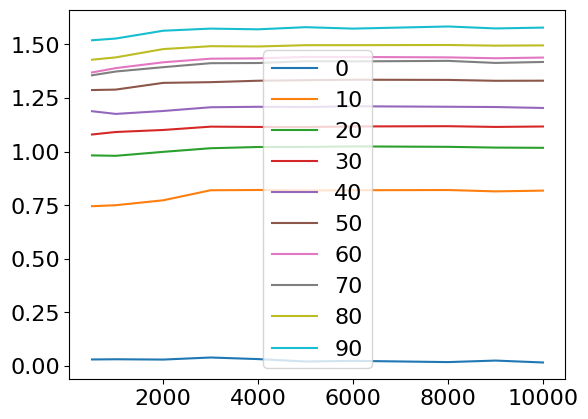

In [30]:
import numpy as np
data = []
widths = sorted(list(mup_width_df.keys()))
for w in widths:
    d = mup_width_df[w]['act mean(abs(a3))'].to_numpy()[np.newaxis]
    #print(d.shape)
    data += [d[:, :100]]
data = np.concatenate(data, axis=0)
for i in range(10):
    plt.plot(widths, data.T[i*10], label=f'{i*10}')
plt.legend()
plt.show()

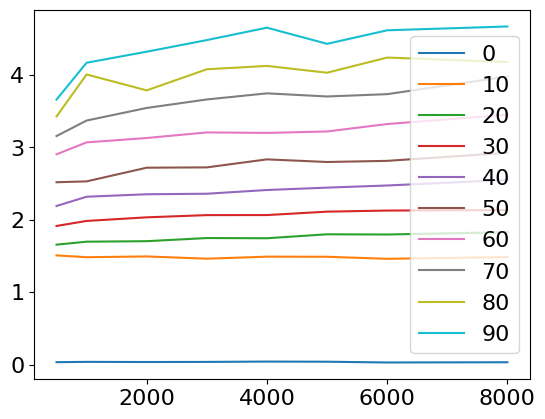

In [31]:
data = []
widths = sorted(list(std_width_df.keys()))
for w in widths:
    d = std_width_df[w]['act mean(abs(a3))'].to_numpy()[np.newaxis]
    data += [d[:, :100]]
data = np.concatenate(data, axis=0)
for i in range(10):
    plt.plot(widths, data.T[i*10], label=f'{i*10}')
plt.legend()
plt.show()

# spectral norm and activation change

In [32]:
std_width_df[500].columns

Index(['test_acc', 'act norm a3', 'act mean(abs(a3))', 'act norm h2',
       'act mean(abs(a2))', 'act norm a1', 'grad mean(abs(grad_fc3.weight))',
       'act mean(abs(h1))', 'grad norm fc2.weight', 'grad norm fc3.weight',
       'val_loss', 'grad norm fc1.weight', '_runtime', 'act norm h1',
       'test_loss', 'train_loss', 'act mean(abs(a1))', '_step',
       'act mean(abs(h2))', 'act norm a2', 'epoch', 'val_acc', '_timestamp',
       'trainer/global_step', 'grad mean(abs(grad_fc1.weight))',
       'grad mean(abs(grad_fc2.weight))'],
      dtype='object')

In [38]:
mup_width_summary

{500: {'val_acc': 0.47269999980926514, '_runtime': 32.347447918, '_step': 55, '_timestamp': 1729555733.4380567, '_wandb': {'runtime': 32}, 'act mean(abs(a1))': 0.514373242855072, 'act mean(abs(a2))': 0.8822429776191711, 'act mean(abs(a3))': 1.2744770050048828, 'act mean(abs(h1))': 0.2699071764945984, 'act mean(abs(h2))': 0.7155740261077881, 'act norm a1': 14.8414306640625, 'act norm a2': 24.83656120300293, 'act norm a3': 4.795745849609375, 'act norm h1': 10.881426811218262, 'act norm h2': 23.26495361328125, 'epoch': 11, 'grad mean(abs(grad_fc1.weight))': 0.0006818624096922576, 'grad mean(abs(grad_fc2.weight))': 0.0002326926332898438, 'grad mean(abs(grad_fc3.weight))': 0.009365949779748917, 'grad norm fc1.weight': 1.1294314861297607, 'grad norm fc2.weight': 0.1770228147506714, 'grad norm fc3.weight': 0.9531362056732178, 'train_loss': 1.655557632446289, 'trainer/global_step': 2249, 'val_loss': 1.501269817352295},
 1000: {'val_acc': 0.5235999822616577, '_runtime': 72.157575813, '_step': 1

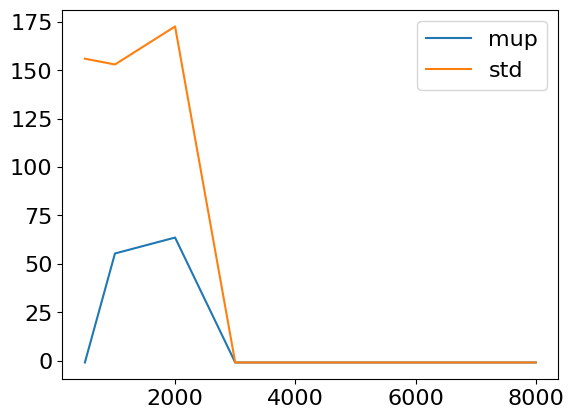

In [50]:
mup_data = []
std_data = []
key = 'spectral_norm_W1'
key = 'act_change_a3'
for w in widths:
    if key in mup_width_summary[w]:
        mup_data += [mup_width_summary[w][key]]
    else:
        mup_data += [-1]
    
    if key in std_width_summary[w]:
        std_data += [std_width_summary[w][key]]
    else:
        std_data += [-1]


plt.plot(widths, mup_data, label='mup')
plt.plot(widths, std_data, label='std')
plt.legend()
plt.show()